# HW2: Data Mining Bert model
- Author: Quentin Ducoulombier (312551811)

## Step 1: Set Up the Environment

In [25]:
# Import necessary libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import libraries for deep learning
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Import the BERT model and tokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

import unicodedata
import re
import emoji

## Step 2: Load the Data

In [51]:
# Function to load data from a JSON file and convert it into a pandas DataFrame
def load_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return pd.DataFrame(data)

# Paths to the data files (adjust the paths as necessary)
train_path = '/kaggle/input/dataset2/train.json'
test_path = '/kaggle/input/dataset2/test.json'

# Load the data
train_data = load_data(train_path)
test_data = load_data(test_path)

# Summary statistics for numerical data
print("\nTraining Data Summary:")
print(train_data.describe())
print("\nTest Data Summary:")
print(test_data.describe())


Training Data Summary:
             rating  helpful_vote
count  35000.000000  35000.000000
mean       2.993457      0.925514
std        1.415602      5.262907
min        1.000000      0.000000
25%        2.000000      0.000000
50%        3.000000      0.000000
75%        4.000000      1.000000
max        5.000000    430.000000

Test Data Summary:
       helpful_vote
count  35000.000000
mean       0.946086
std        5.540449
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      607.000000


## Step 3: Preprocessing

In [27]:
def preprocess_texts(texts, titles=None):
    processed_texts = []
    for i, text in enumerate(texts):
        if titles and i < len(titles):  # Ensure the title index exists
            text = f"{titles[i]}. " + text  # Concatenate title and text
        
        # Convert to lowercase
        text = text.lower()
        
        # Transforms emoji ?
        text = emoji.demojize(text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove any text within double square brackets (like video IDs)
        text = re.sub(r"\[\[.*?\]\]", "", text)

        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove backslash from apostrophes
        text = re.sub(r"\\'", "'", text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove repeated punctuation (e.g., "!!!" -> "!")
        text = re.sub(r'([!?.]){2,}', r'\1', text)

        # Standardize apostrophes and quotes
        text = text.replace("‘", "'").replace("’", "'").replace("“", '"').replace("”", '"')

        # Handle partially decoded HTML entities
        text = re.sub(r'&#\d+;', '', text)
        
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

        processed_texts.append(text)
        
    #print(processed_texts)

    return processed_texts


In [28]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Visualizing Sequence Length Distribution

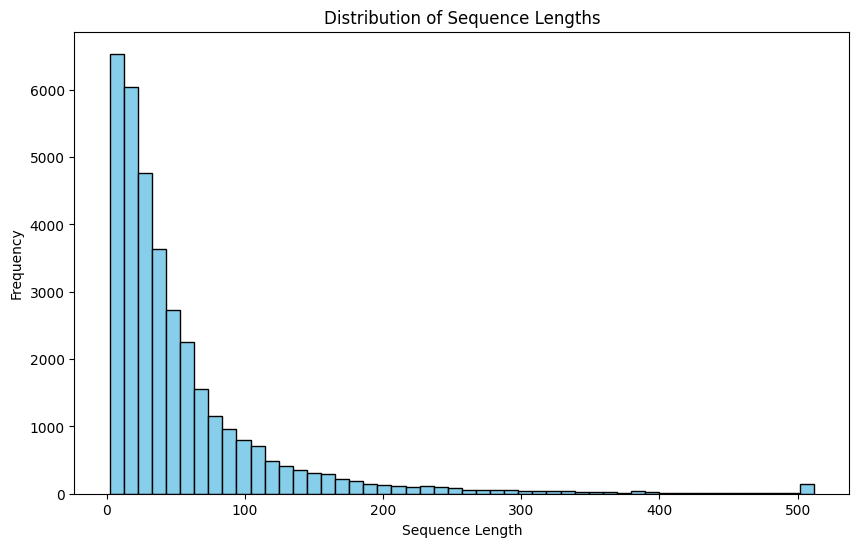

In [29]:
# Tokenize the texts and calculate the length of the sequences
train_data['token_length'] = train_data['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

# Visualize the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(train_data['token_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

### Determining Optimal `max_len`

In [30]:
# Calculate descriptive statistics
length_stats = train_data['token_length'].describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
print(length_stats)

# Choose a value of `max_len` that covers 95% of the sequences
max_len = int(length_stats['95%'])
print(f'Choose max_len = {max_len}')

count    35000.000000
mean        54.765229
std         67.916398
min          2.000000
50%         33.000000
75%         65.000000
80%         77.000000
85%         95.000000
90%        122.000000
95%        179.000000
99%        368.000000
max        512.000000
Name: token_length, dtype: float64
Choose max_len = 179


In [31]:
# Function to encode the cleaned text data
def encode_texts(texts, max_len=max_len):
    encoded = tokenizer(texts,
                        padding=True,
                        truncation=True,
                        max_length=max_len,
                        return_tensors="tf",
                        add_special_tokens=True)
    return encoded

In [32]:
# Main preprocessing function
def preprocess_data():
    data = train_data
    processed_texts = preprocess_texts(data['text'].tolist(), data['title'].tolist())
    encoded_texts = encode_texts(processed_texts)
    labels = data['rating'].values.astype('int32') - 1  # Adjust labels to be zero-indexed
    
    # Determine sizes for splitting
    test_size = int(0.2 * len(encoded_texts['input_ids']))
    train_size = len(encoded_texts['input_ids']) - test_size
    
    # Prepare training and validation datasets
    X_train = {'input_ids': encoded_texts['input_ids'][:train_size],
               'attention_mask': encoded_texts['attention_mask'][:train_size]}
    X_val = {'input_ids': encoded_texts['input_ids'][train_size:],
             'attention_mask': encoded_texts['attention_mask'][train_size:]}
    
    y_train = tf.convert_to_tensor(labels[:train_size])
    y_val = tf.convert_to_tensor(labels[train_size:])
    
    return X_train, y_train, X_val, y_val

In [33]:
X_train, y_train, X_val, y_val = preprocess_data()

In [52]:
# Commenting out the print statements
#print("X_train['input_ids']:", X_train['input_ids'])
#print("X_train['attention_mask']:", X_train['attention_mask'])
#print("X_val['input_ids']:", X_val['input_ids'])
#print("X_val['attention_mask']:", X_val['attention_mask'])
#print("Updated X_val:", X_val)
#print("y_train:", y_train)
#print("y_val:", y_val)

#print("Number of samples in 'input_ids':", len(X_train['input_ids']))
#print("Number of samples in 'attention_mask':", len(X_train['attention_mask']))
#print("Number of samples in 'y_train':", len(y_train))


### With `helpful_vote`

In [ ]:
# scaler = MinMaxScaler()
# train_data['helpful_vote_normalized'] = scaler.fit_transform(train_data[['helpful_vote']])
# test_data['helpful_vote_normalized'] = scaler.transform(test_data[['helpful_vote']])

In [ ]:
# def encode_texts_and_votes(texts, votes, max_len=max_len):
#     encoded = tokenizer(texts,
#                         padding='max_length',
#                         truncation=True,
#                         max_length=max_len,
#                         return_tensors="tf",
#                         add_special_tokens=True)
#     votes_tensor = tf.convert_to_tensor(votes, dtype=tf.float32)
#     return encoded, votes_tensor

In [ ]:
# def preprocess_data_with_vote():
#     data = train_data
#     processed_texts = preprocess_texts(data['text'].tolist(), data['title'].tolist())
#     encoded_texts, votes_tensor = encode_texts_and_votes(processed_texts, data['helpful_vote_normalized'].values)
#     labels = data['rating'].values.astype('int32') - 1  # Adjust labels to be zero-indexed
    
#     # Determine sizes for splitting
#     test_size = int(0.2 * len(encoded_texts['input_ids']))
#     train_size = len(encoded_texts['input_ids']) - test_size
    
#     # Convert inputs to TensorFlow tensors
#     input_ids = tf.convert_to_tensor(encoded_texts['input_ids'], dtype=tf.int32)
#     attention_mask = tf.convert_to_tensor(encoded_texts['attention_mask'], dtype=tf.int32)
    
#     # Prepare training and validation datasets
#     X_train = {'input_ids': input_ids[:train_size],
#                'attention_mask': attention_mask[:train_size],
#                'helpful_vote': votes_tensor[:train_size]}
#     X_val = {'input_ids': input_ids[train_size:],
#              'attention_mask': attention_mask[train_size:],
#              'helpful_vote': votes_tensor[train_size:]}
    
#     y_train = tf.convert_to_tensor(labels[:train_size])
#     y_val = tf.convert_to_tensor(labels[train_size:])
    
#     return X_train, y_train, X_val, y_val

In [ ]:
#X_train, y_train, X_val, y_val = preprocess_data_with_vote()

In [ ]:
#print("X_train['input_ids']:", X_train['input_ids'])
#print("X_train['attention_mask']:", X_train['attention_mask'])
#print("X_train['helpful_vote']:", X_train['helpful_vote'])

#print("X_val['input_ids']:", X_val['input_ids'])
#print("X_val['attention_mask']:", X_val['attention_mask'])
#print("X_val['helpful_vote']:", X_val['helpful_vote'])

#print("Updated X_val:", X_val)
#print("y_train:", y_train)
#print("y_val:", y_val)

#print("Number of samples in 'input_ids':", len(X_train['input_ids']))
#print("Number of samples in 'attention_mask':", len(X_train['attention_mask']))
#print("Number of samples in 'y_train':", len(y_train))

## Step 4: Prepare Dataset

In [35]:
# Function to create a TensorFlow dataset object from input features and labels
def create_dataset(input_ids, attention_masks, labels, batch_size=16, shuffle=True):

    # Create a TensorFlow dataset object
    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, 
                                                   "attention_mask": attention_masks}, 
                                                  labels))
    # Shuffle the dataset if specified
    if shuffle:
        dataset = dataset.shuffle(10000)  # Shuffle buffer size set as 10,000

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Prefetch to optimize speed
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [36]:
# Parameters
batch_size = 32

# Create training and validation datasets
train_dataset = create_dataset(X_train['input_ids'], X_train['attention_mask'], y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val['input_ids'], X_val['attention_mask'], y_val, batch_size=batch_size, shuffle=False)

### With `helpful_vote`

In [ ]:
# def create_dataset_with_votes(input_ids, attention_masks, votes, labels, batch_size=16, shuffle=True):
#     dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, 
#                                                    "attention_mask": attention_masks,
#                                                    "helpful_vote": votes}, 
#                                                   labels))
#     if shuffle:
#         dataset = dataset.shuffle(10000)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#     return dataset

In [ ]:
# # Parameters
# batch_size = 16

# # Create training and validation datasets with helpful_vote

# train_dataset = create_dataset_with_votes(X_train['input_ids'], X_train['attention_mask'], X_train['helpful_vote'], y_train, batch_size=batch_size)
# val_dataset = create_dataset_with_votes(X_val['input_ids'], X_val['attention_mask'], X_val['helpful_vote'], y_val, batch_size=batch_size, shuffle=False)

## Step 5: Load Pretrained BERT Model

In [37]:
# Function to load a pre-trained BERT model with a sequence classification head
def load_pretrained_bert_model(num_labels, model_name='bert-base-uncased'):
    
    # Load the configuration from the BERT model
    config = BertConfig.from_pretrained(model_name, num_labels=num_labels)
    
    # Load the TensorFlow BERT model with a sequence classification head
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    return model

In [53]:
# Number of rating categories (assuming ratings are from 1 to 5)
num_labels = 5

# Load the BERT model
bert_model = load_pretrained_bert_model(num_labels)

# Model summary
#bert_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### With `helpful_vote`

In [ ]:
# def load_pretrained_bert_model_with_votes(num_labels, model_name='bert-base-uncased'):
#     # Load the TensorFlow BERT model
#     bert_model = TFBertModel.from_pretrained(model_name)
    
#     # Define input layers
#     input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
#     attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
#     helpful_vote = Input(shape=(1,), dtype=tf.float32, name='helpful_vote')
    
#     # Get BERT model output
#     bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)[1]
    
#     # Concatenate BERT output with helpful_vote feature
#     concatenated = Concatenate()([bert_output, helpful_vote])
    
#     # Add dense layers for classification
#     dense_output = Dense(128, activation='relu')(concatenated)
#     dense_output = Dropout(0.2)(dense_output)
#     dense_output = Dense(num_labels, activation='softmax')(dense_output)
    
#     # Create the final model
#     model = Model(inputs=[input_ids, attention_mask, helpful_vote], outputs=dense_output)
    
#     return model

In [ ]:
# # Number of rating categories (assuming ratings are from 1 to 5)
# num_labels = 5

# # Load the BERT model
# bert_model = load_pretrained_bert_model_with_votes(num_labels)
# # Model summary
# bert_model.summary()

## Step 6: Model Training

In [39]:
# Function to compile and train the BERT model on the training dataset with validation
def compile_and_train_model(model, train_dataset, val_dataset, learning_rate=2e-5, epochs=2):

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        verbose=1)

    return history, model

In [40]:
history, model = compile_and_train_model(bert_model, train_dataset, val_dataset)

Epoch 1/2
875/875 [==============================] - 705s 732ms/step - loss: 0.9819 - accuracy: 0.5719 - val_loss: 0.8402 - val_accuracy: 0.6306
Epoch 2/2
875/875 [==============================] - 628s 718ms/step - loss: 0.7656 - accuracy: 0.6706 - val_loss: 0.8612 - val_accuracy: 0.6251


In [41]:
# Function to plot the training and validation loss and accuracy from the training history
def plot_training_history(history):

    # Accessing history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

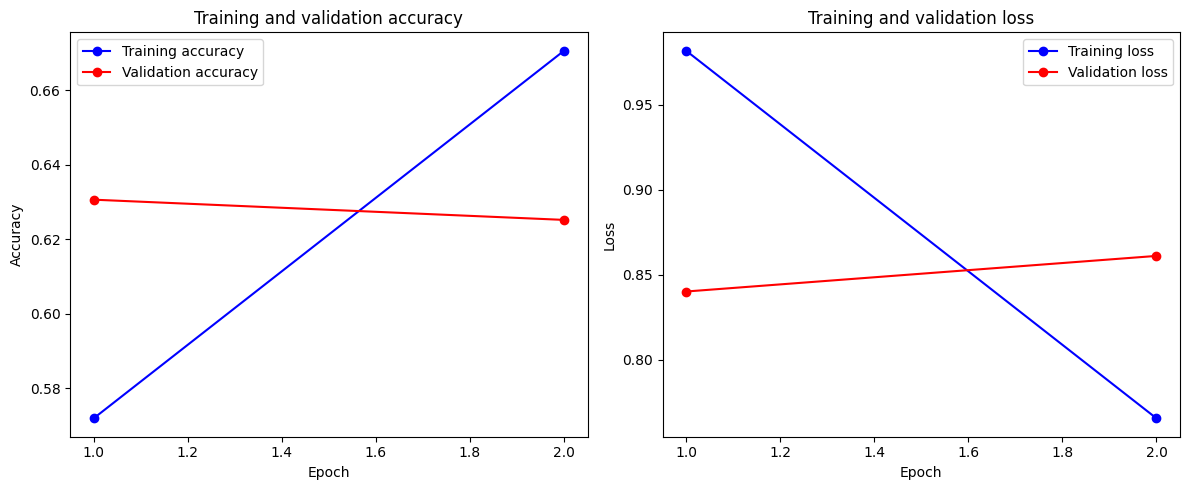

In [42]:
plot_training_history(history)

## Step 7: Model Evaluation

In [43]:
# Function to evaluate the trained model on a given dataset, print performance metrics, and plot a confusion matrix
def evaluate_model(model, dataset, label_names):

    # Generate predictions for the dataset
    print("Evaluating the model...")
    predictions = model.predict(dataset)
    predicted_labels = np.argmax(predictions.logits, axis=1)

    # Extract true labels from the dataset
    true_labels = []
    for batch in dataset.unbatch():
        true_labels.append(batch[1].numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print("\nClassification Report:")
    report = classification_report(true_labels, predicted_labels, target_names=label_names)
    print(report)

    # Calculate and print F1-score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # or 'macro', 'micro'
    print(f"\nWeighted F1-Score: {f1}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Evaluating the model...
219/219 [==============================] - 60s 228ms/step

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.62      0.68      1395
           2       0.50      0.63      0.56      1426
           3       0.55      0.53      0.54      1394
           4       0.63      0.60      0.61      1414
           5       0.76      0.75      0.75      1371

    accuracy                           0.63      7000
   macro avg       0.64      0.63      0.63      7000
weighted avg       0.64      0.63      0.63      7000


Weighted F1-Score: 0.6278329468009816


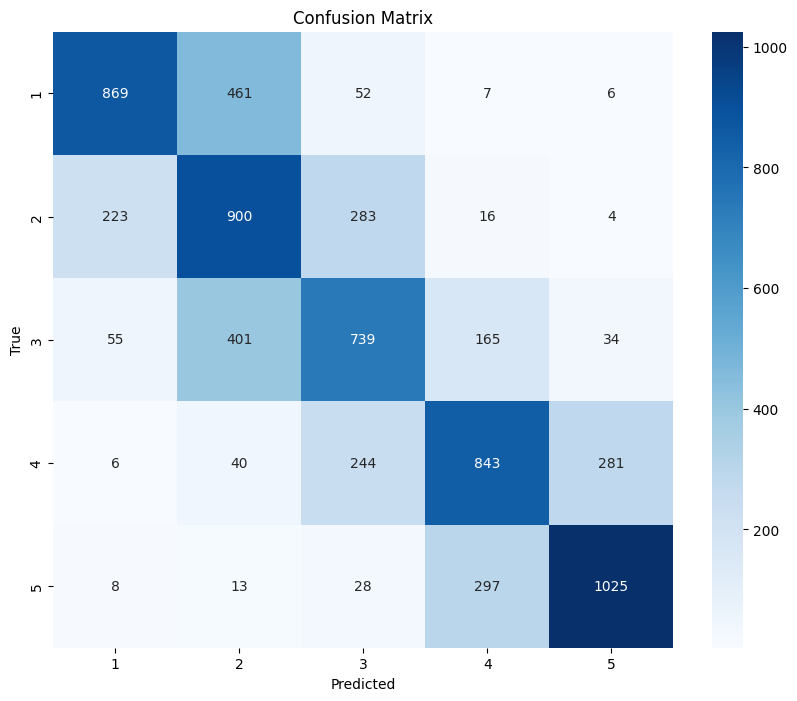

In [44]:
label_names = ['1', '2', '3', '4', '5']

# Example usage: Evaluate on the validation dataset
evaluate_model(model, val_dataset, label_names)

## Step 8: Submission Preparation

In [45]:
# Function to generate predictions for the test dataset, format them for submission, and save to a CSV file
def prepare_submission(model, test_dataset, submission_file_path):
    # Generate predictions for the test dataset
    print("Generating predictions for the test dataset...")
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions.logits, axis=1) + 1  # Convert zero-indexed labels back to 1-5 scale
    print(predicted_labels)
    
    # Create a DataFrame for the submission
    submission_df = pd.DataFrame({
        'index': [f"index_{i}" for i in range(len(predicted_labels))],
        'rating': predicted_labels
    })

    # Save the DataFrame to a CSV file
    submission_df.to_csv(submission_file_path, header=True, index=False)
    print(f"Submission file saved to {submission_file_path}")
    return predicted_labels


In [48]:
data = test_data
test = preprocess_texts(data['text'].tolist(), data['title'].tolist())
encoded_dict = encode_texts(test)

In [49]:
submission_file_path = 'submission.csv' 
predicted_labels= prepare_submission(model, encoded_dict, submission_file_path)

Generating predictions for the test dataset...
1094/1094 [==============================] - 249s 227ms/step
[1 1 5 ... 1 1 2]
Submission file saved to submission_6.csv


In [50]:
predicted_labels

array([1, 1, 5, ..., 1, 1, 2])